In [ ]:
!pip install torch
import torch

def format_pytorch_version(version):
  return version.split('+')[0]

TORCH_version = torch.__version__
TORCH = format_pytorch_version(TORCH_version)

def format_cuda_version(version):
  return 'cu' + version.replace('.', '')

CUDA_version = torch.version.cuda
CUDA = format_cuda_version(CUDA_version)

!pip install torch-scatter     -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-sparse      -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-cluster     -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-spline-conv -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-geometric

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 22.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 49.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 31.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 109.1 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitli

In [ ]:
!pip install torch-geometric-temporal

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.9/98.9 kB 3.5 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
DATA_DIR = '/content/drive/MyDrive/SNA/data'
MODEL_PATH = '/content/drive/MyDrive/SNA/model/model.pth'
import pandas as pd
import os

# Modify this to match your actual Google Drive folder structure
DRIVE_BASE = '/content/drive/MyDrive/SNA'
DATA_DIR = os.path.join(DRIVE_BASE, 'data')
JSON_OUT_DIR = DRIVE_BASE
MAPPED_OUT_DIR = os.path.join(DRIVE_BASE, 'data/mapped')
edge_type_features_mapped = f'{MAPPED_OUT_DIR}/edge_type_features_mapped.csv'
edges_train_A_mapped = f'{MAPPED_OUT_DIR}/edges_train_A_mapped.csv'
node_features_mapped = f'{MAPPED_OUT_DIR}/node_features_mapped.csv'



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


PREPROCESS

In [ ]:
!pip install scikit-learn
!pip install tqdm
!pip install pandas
!pip install numpy

In [11]:
# train_with_edge_types.py

# --- Colab Drive mount (if using Colab) ---
from google.colab import drive
drive.mount('/content/drive')

import os
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from torch_geometric_temporal.nn.recurrent import GConvGRU
from tqdm import tqdm

# --- Paths (adjust if running locally) ---
DRIVE_BASE       = '/content/drive/MyDrive/SNA'
MAPPED_OUT_DIR   = os.path.join(DRIVE_BASE, 'data', 'mapped', "real")
MODEL_PATH       = os.path.join(DRIVE_BASE, 'model', 'model.pth')

EDGES_PATH       = os.path.join(MAPPED_OUT_DIR, 'edges_train_A_mapped.csv')
NODE_FEAT_PATH   = os.path.join(MAPPED_OUT_DIR, 'node_features_mapped.csv')
ETYPE_FEAT_PATH  = os.path.join(MAPPED_OUT_DIR, 'edge_type_features_mapped.csv')


# --- Model (now includes edge-type features) ---
class GConvGRULinkPredictor(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, etype_feat_dim):
        super().__init__()
        self.recurrent = GConvGRU(in_channels, hidden_channels, K=2)
        self.link_pred = torch.nn.Sequential(
            torch.nn.Linear(2 * hidden_channels + etype_feat_dim,
                            hidden_channels),
            torch.nn.ReLU(),
            torch.nn.Linear(hidden_channels, 1),
        )

    def forward(self, x, edge_index):
        # returns hidden states h for all nodes
        return self.recurrent(x, edge_index)

    def predict(self, h, pairs, etype_feats):
        # pairs: [num_samples, 3] = (src, dst, etype)
        src   = pairs[:, 0]
        dst   = pairs[:, 1]
        etype = pairs[:, 2]
        h_src = h[src]                           # [num_samples, H]
        h_dst = h[dst]                           # [num_samples, H]
        efeat = etype_feats[etype]               # [num_samples, E]
        inp   = torch.cat([h_src, h_dst, efeat], dim=1)  # [num_samples, 2H+E]
        return self.link_pred(inp).squeeze()     # [num_samples]


# --- Dataset (yields node-features, graph, pairs, labels, etype-features) ---
class TemporalLinkPredictionDataset(Dataset):
    def __init__(self,
                 edges_path: str,
                 num_nodes: int,
                 node_feat_path: str,
                 etype_feat_path: str,
                 neg_sample_ratio: float = 1.0):
        # 1) load time-stamped edges (already remapped IDs)
        self.edges = pd.read_csv(
            edges_path,
            names=['src','dst','etype','ts']
        )
        self.timestamps = sorted(self.edges['ts'].unique())
        # 2) load node feature matrix [num_nodes, F]
        self.node_features = torch.from_numpy(
            pd.read_csv(node_feat_path, header=None).values
        ).float()
        # 3) load edge-type feature matrix [num_etypes, E]
        self.etype_feats = torch.from_numpy(
            pd.read_csv(etype_feat_path, header=None).values
        ).float()
        self.num_nodes = num_nodes
        self.neg_ratio = neg_sample_ratio

    def __len__(self):
        # one training sample per time-interval
        return len(self.timestamps) - 1

    def __getitem__(self, idx):
        # time window [t, t_next]
        t      = self.timestamps[idx]
        t_next = self.timestamps[idx + 1]

        # build historical graph up to time t
        hist = self.edges[self.edges.ts <= t]
        edge_arr = np.vstack([hist.src.values, hist.dst.values])
        edge_index = torch.from_numpy(edge_arr).long()

        # positive samples in (t, t_next]
        pos = self.edges[
            (self.edges.ts > t) & (self.edges.ts <= t_next)
        ][['src','dst','etype']].values
        K   = len(pos)

        # negative sampling: uniform over nodes and etypes
        neg_src   = np.random.randint(0, self.num_nodes, size=int(K*self.neg_ratio))
        neg_dst   = np.random.randint(0, self.num_nodes, size=int(K*self.neg_ratio))
        neg_etype = np.random.randint(0, self.etype_feats.size(0), size=int(K*self.neg_ratio))
        neg = np.stack([neg_src, neg_dst, neg_etype], axis=1)

        # assemble pairs and labels
        pairs  = torch.from_numpy(np.vstack([pos, neg])).long()   # [2K,3]
        labels = torch.cat([
            torch.ones(K),
            torch.zeros(int(K*self.neg_ratio))
        ]).float()                                               # [2K]

        return {
            'x':           self.node_features,   # [N, F]
            'edge_index':  edge_index,           # [2, num_hist_edges]
            'pairs':       pairs,                # [2K, 3]
            'labels':      labels,               # [2K]
            'etype_feats': self.etype_feats      # [num_etypes, E]
        }


# --- Training function ---
def train_model_A(edges_path: str,
                  node_feat_path: str,
                  etype_feat_path: str,
                  num_nodes: int,
                  hidden_channels: int = 64,
                  epochs: int = 10,
                  lr: float = 1e-4):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print("Using device:", device)

    # dataset & loader
    dataset = TemporalLinkPredictionDataset(
        edges_path      = edges_path,
        num_nodes       = num_nodes,
        node_feat_path  = node_feat_path,
        etype_feat_path = etype_feat_path,
        neg_sample_ratio= 1.0
    )
    loader = DataLoader(
        dataset,
        batch_size=None,
        shuffle=False,
        num_workers=1,
        pin_memory=False
    )

    # model init (include etype feature dim)
    model = GConvGRULinkPredictor(
        in_channels     = dataset.node_features.shape[1],
        hidden_channels = hidden_channels,
        etype_feat_dim  = dataset.etype_feats.shape[1]
    ).to(device)

    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=0.01)
    criterion = torch.nn.BCEWithLogitsLoss()

    best_loss = float('inf')
    for epoch in range(1, epochs + 1):
        model.train()
        total_loss = 0.0
        good_batches = 0

        for batch in tqdm(loader, desc=f"Epoch {epoch}/{epochs}"):
            x       = batch['x'].to(device)
            ei      = batch['edge_index'].to(device)
            pairs   = batch['pairs'].to(device)
            labels  = batch['labels'].to(device)
            et_feats= batch['etype_feats'].to(device)

            optimizer.zero_grad()
            h       = model(x, ei)
            logits  = model.predict(h, pairs, et_feats)
            loss    = criterion(logits, labels)

            if torch.isnan(loss):
                print(f"→ NaN loss at epoch {epoch}, skipping batch")
                continue

            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()

            total_loss += loss.item()
            good_batches += 1

        avg_loss = total_loss / max(good_batches, 1)
        print(f"Epoch {epoch} avg loss: {avg_loss:.4f}")

        if avg_loss < best_loss:
            best_loss = avg_loss
            torch.save(model.state_dict(), MODEL_PATH)
            print(f"↳ Saved best model (loss: {best_loss:.4f})")

    return model


# --- Launch training ---
if __name__ == "__main__":
    # ensure num_nodes matches your mapped node_features.csv row count
    NUM_NODES = 19442

    model = train_model_A(
        edges_path      = EDGES_PATH,
        node_feat_path  = NODE_FEAT_PATH,
        etype_feat_path = ETYPE_FEAT_PATH,
        num_nodes       = NUM_NODES,
        hidden_channels = 64,
        epochs          = 10,
        lr              = 1e-4
    )


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Using device: cuda


Epoch 1/10: 100%|██████████| 22504/22504 [36:01<00:00, 10.41it/s]


Epoch 1 avg loss: 0.0905
↳ Saved best model (loss: 0.0905)


Epoch 2/10:  79%|███████▉  | 17857/22504 [24:16<06:18, 12.26it/s]


KeyboardInterrupt: 

#INFERENCE

##SETUP

In [15]:
!pip install matplotlib
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/SNA

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/SNA


#LOAD DATA

In [16]:
import json, pandas as pd, numpy as np, torch
from torch_geometric_temporal.nn.recurrent import GConvGRU
import torch.nn as nn

# Load maps
with open("node_id_map.json") as f:
    node_map = {int(k):v for k,v in json.load(f).items()}
with open("etype_id_map.json") as f:
    etype_map = {int(k):v for k,v in json.load(f).items()}

# Load features & edges
node_feats = torch.from_numpy(pd.read_csv("data/mapped/real/node_features_mapped.csv", header=None).values).float()
etype_feats = torch.from_numpy(pd.read_csv("data/mapped/real/edge_type_features_mapped.csv", header=None).values).float()
train_edges = pd.read_csv("data/mapped/real/edges_train_A_mapped.csv", names=["src","dst","etype","ts"])

# Define model
class GConvGRULinkPredictor(nn.Module):
    def __init__(self, in_ch, hid_ch, et_ch):
        super().__init__()
        self.recurrent = GConvGRU(in_ch, hid_ch, K=2)
        self.link_pred = nn.Sequential(nn.Linear(2*hid_ch+et_ch, hid_ch), nn.ReLU(), nn.Linear(hid_ch,1))
    def forward(self, x, edge_index):
        return self.recurrent(x, edge_index)
    def predict(self, h, pairs, e_feats):
        s,d,e = pairs[:,0], pairs[:,1], pairs[:,2]
        hs, hd = h[s], h[d]
        ef = e_feats[e]
        return self.link_pred(torch.cat([hs,hd,ef],1)).squeeze()

# Load trained model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = GConvGRULinkPredictor(node_feats.size(1), 64, etype_feats.size(1)).to(device)
model.load_state_dict(torch.load("model/model.pth", map_location=device))
model.eval()


GConvGRULinkPredictor(
  (recurrent): GConvGRU(
    (conv_x_z): ChebConv(8, 64, K=2, normalization=sym)
    (conv_h_z): ChebConv(64, 64, K=2, normalization=sym)
    (conv_x_r): ChebConv(8, 64, K=2, normalization=sym)
    (conv_h_r): ChebConv(64, 64, K=2, normalization=sym)
    (conv_x_h): ChebConv(8, 64, K=2, normalization=sym)
    (conv_h_h): ChebConv(64, 64, K=2, normalization=sym)
  )
  (link_pred): Sequential(
    (0): Linear(in_features=131, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=1, bias=True)
  )
)

#BATCHED INFERENCE

AUC = 0.4639


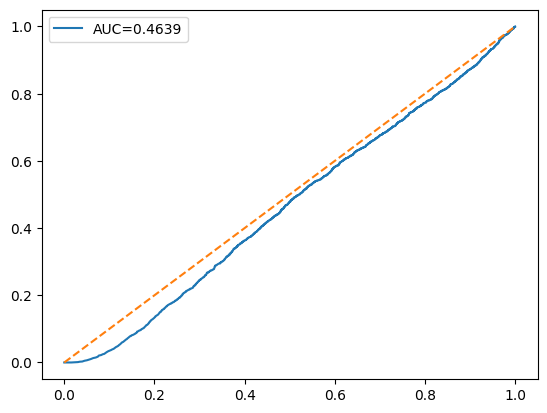

Saved predictions to output/output_A.csv


In [17]:
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# Load and map test
test = pd.read_csv("data/input_A.csv", names=["src_id","dst_id","etype_raw","start","end","label"])
test["src"]   = test["src_id"].map(node_map)
test["dst"]   = test["dst_id"].map(node_map)
test["etype"] = test["etype_raw"].map(etype_map)
test = test.dropna(subset=["src","dst","etype"]).astype(int).reset_index(drop=True)

# Move to device
node_feats = node_feats.to(device)
etype_feats = etype_feats.to(device)

# Batched by timestamp
preds = np.zeros(len(test))
labels = test["label"].values
groups = test.groupby("start").groups

for t, idxs in groups.items():
    sub = train_edges[train_edges.ts <= t]
    if sub.empty:
        edge_index = torch.empty((2,0),dtype=torch.long,device=device)
    else:
        arr = np.vstack([sub.src.values, sub.dst.values])
        edge_index = torch.from_numpy(arr).long().to(device)
    h = model(node_feats, edge_index)
    batch = test.loc[idxs, ["src","dst","etype"]].values
    pairs = torch.from_numpy(batch).long().to(device)
    with torch.no_grad():
        logits = model.predict(h, pairs, etype_feats)
        probs = torch.sigmoid(logits).cpu().numpy()
    preds[idxs] = probs

# AUC & ROC
auc = roc_auc_score(labels, preds)
print(f"AUC = {auc:.4f}")
fpr, tpr, _ = roc_curve(labels, preds)
plt.plot(fpr, tpr, label=f"AUC={auc:.4f}")
plt.plot([0,1],[0,1],"--"); plt.legend(); plt.show()

# Save predictions
pred_df = test[["src_id","dst_id","etype_raw","start","end","label"]].copy()
pred_df["pred_prob"] = preds
out_path = "output/output_A.csv"
pred_df.to_csv(out_path, index=False)
print(f"Saved predictions to {out_path}")
